<a href="https://colab.research.google.com/github/Ayesha-Imr/Knowledge-Graph-With-ApertureDB/blob/main/ApertureDB_Knowledge_Graph_with_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating A Knowledge Graph Using ApertureDB and Gemini

Welcome to this tutorial on building a knowledge graph from your documents using ApertureDB and Gemini 2.5 Flash!

Knowledge graphs are powerful ways to organize data visually, connecting entities through clear, meaningful relationships. They’re especially helpful for making Retrieval-Augmented Generation (RAG) systems smarter, providing accurate, context-rich responses. Companies using knowledge graphs with RAG have seen noticeable improvements, including nearly 30% faster customer issue resolutions ([arxiv.org](https://arxiv.org/abs/2404.17723)) and better transparency in how AI models generate answers.

For managing and querying our knowledge graph, we're using [ApertureDB](https://www.aperturedata.io/), a versatile multimodal database built specifically for handling structured metadata alongside images, videos, and other rich media. ApertureDB lets us quickly set up and explore complex relationships between different data types, which makes analyzing and retrieving information intuitive and efficient.

We’ve chosen [Gemini 2.5 Flash](https://cloud.google.com/vertex-ai/generative-ai/docs/models/gemini/2-5-flash) as our LLM of choice because of its large context window and fast response times, perfect for smoothly processing and extracting detailed insights from lengthy documents.

LangChain has been utilised to orchestrate the graph-generation workflow , particularly its  RunnableParallel feature to run multiple tasks side-by-side, speeding up the entire process.

For the input data I used to build a knowledge in this tutorial are my Cloud Computing lecture course notes in PDF form (I have my exams coming up so this was like killing two birds with one stone!). The PDF consists of 42 pages (!) so this shows the impressive capability of this workflow for knowledge graph creation.

While in this tutorial we will only explore how to CREATE a knowledge graph, in the next part, we'll see how to use this created knowledge graph for RAG (Retrieval Augmented Generation).

Let's get started and build your very own knowledge graph!

 ## Environment Setup and Dependency Installation

### Creating an ApertureDB instance

Before you begin, you may set up your ApertureDB instance. ApertureDB provides a 30-day free trial. Use these [docs](https://docs.aperturedata.io/Setup/server/Cloud) to set up your 30-days-free instance. Make sure to copy the host name and the password in Colab Secrets.

First, we install all the libraries needed for the notebook.

In [3]:
# install required packages for Google Colab
!pip install --quiet langchain langchain-google-genai langchain-community langchain-core langchain-text-splitters tqdm pydantic networkx pyvis aperturedb python-dotenv pypdf google-generativeai


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━

Next, import all the libraries and packages we'll be using throughout this tutorial.

In [4]:
# import required libraries
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnableParallel, RunnableLambda
from pydantic import BaseModel, Field
from typing import Dict, List, Any, Optional
from collections import Counter
import os
import json
import asyncio
import uuid
import logging
from tqdm import tqdm
import time
from dotenv import load_dotenv
import concurrent.futures
import networkx as nx
from pyvis.network import Network
from IPython.display import IFrame, display
from google.colab import files
from google.colab import userdata, auth
import google.generativeai as genai
from aperturedb import Connector


Authenticate your environment to use Google Gemini API services seamlessly within Google Colab.

In [37]:
# you need to be authenticated to  use Gemini API
auth.authenticate_user()

Set up logging to track progress and debug effectively. This helps monitor the workflow clearly.

In [5]:
# set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

Set environment variables for Google Gemini and ApertureDB securely from Colab secrets. You can get an API Key to use for Gemini [here](https://aistudio.google.com/apikey).

In [136]:
# load the environment variables from colab secrets
google_api_key = userdata.get("GOOGLE_API_KEY")
db_host = userdata.get("APERTUREDB_HOST")
db_password = userdata.get("APERTUREDB_PASSWORD")

# configure gemini API key
os.environ['GOOGLE_API_KEY'] = google_api_key

If the previous step fails, manually input your Gemini API Key.

In [51]:
# if the above doesn't work, input the API key manually
import getpass
os.environ['GOOGLE_API_KEY'] = getpass.getpass('Gemini API Key:')

Gemini API Key:··········


Initialize Gemini 2.5 Flash LLM.

In [5]:
# Initialize the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17",
    temperature=0, # ensure deterministic output
    max_tokens=None, # so that generated output doesn't get cut off
    timeout=None, # to allow for longer responses
    max_retries=2,
)

## Document Loading

Define the function that handles loading and parsing your PDF document. You can load PDFs directly from your local environment or upload them.

In [14]:
def load_pdf_content(pdf_path=None, return_single_string=True, extract_metadata=False):
    """
    Load and parse a PDF document, returning its text content.

    Args:
        pdf_path (str): Path to the PDF file. If None, will prompt for upload in Colab
        return_single_string (bool): If True, returns the entire PDF content as a single string.
                                     If False, returns a list of strings (one per page).
        extract_metadata (bool): If True, returns metadata along with content

    Returns:
        If return_single_string is True and extract_metadata is False:
            str: The entire text content of the PDF
        If return_single_string is False and extract_metadata is False:
            list: List of strings, one for each page
        If extract_metadata is True:
            tuple: (content, metadata) where content is either a string or list based on return_single_string
    """
    # In Google Colab, upload the file if no path is provided
    if pdf_path is None:
        print("Please upload your PDF file...")
        uploaded = files.upload()
        if not uploaded:
            raise ValueError("No file was uploaded")
        pdf_path = list(uploaded.keys())[0]

    # Check if the file exists
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"PDF file not found at: {pdf_path}")

    # Initialize the loader with the appropriate mode
    mode = "single" if return_single_string else "elements"
    loader = PyPDFLoader(pdf_path, mode=mode)

    # Load the documents
    docs = loader.load()

    if return_single_string:
        # With mode="single", there should only be one document containing all pages
        content = docs[0].page_content if docs else ""
        metadata = docs[0].metadata if docs else {}
    else:
        # With default mode, each document is a page
        content = [doc.page_content for doc in docs]
        metadata = [doc.metadata for doc in docs]

    if extract_metadata:
        return content, metadata
    else:
        return content

Load your pdf document

In [22]:
doc = load_pdf_content()

Please upload your PDF file...


Saving Cloud Computing Lecture Notes.pdf to Cloud Computing Lecture Notes (2).pdf


Checking the extracted contents of the PDF

In [24]:
# check length of text
print(f"Length of document: {len(doc)} characters")

# check out first 1000 characters
print(f"First 1000 characters: {doc[:1000]}")


Length of document: 48269 characters
First 1000 characters: Cloud Computing Lecture Notes 
Distributed Computing/Systems 
Definition: 
Distributed computing refers to a system where computing resources are distributed 
across multiple locations rather than being centralized in a single system. This enables 
task distribution and efficient resource utilization. 
Why Use Distributed Systems? 
• Scalability Issues: Traditional computing faces bottlenecks due to hardware 
limitations, whereas distributed systems allow for hardware scaling. 
• Connected Devices: In a networked system, connected devices communicate, but 
this does not necessarily make them distributed. 
• IoT (Internet of Things): IoT is one of the largest examples of distributed computing. 
• Multi-layered System Design: Distributed computing enables systems to function 
in multiple layers, with each layer acting as a distributed entity. 
• User Perspective: Although the system consists of multiple machines, distributed 
co

## Step 1: Entity Class Schema Extraction


In the first step of the workflow, we identify the types of entities present in our document and their possible properties.


This Pydantic model defines the structure for our class schema output, ensuring the LLM returns properly formatted data.

In [25]:
# Define Pydantic model for class schema parser
class ClassSchema(BaseModel):
    """Class types and their properties."""
    classes: Dict[str, List[str]] = Field(
        description="Dictionary mapping class types to their possible properties"
    )

Now we create a function that creates a LangChain chain that extracts entity classes and their properties from text.

In [26]:
# Create class extraction chain
def create_class_extraction_chain():
    parser = JsonOutputParser(pydantic_object=ClassSchema)

    # Prompt template
    prompt = PromptTemplate(
        template="""
    You are the first agent in a multi-step workflow to build a Knowledge Graph from raw text.

    Workflow Steps Overview:
    1. Extract high-level class types and their properties from the text. [CURRENT STEP]
    2. Extract specific entities (instances of classes) and their properties based on the identified types.
    3. Deduplicate extracted entities and assign them unique identifiers.
    4. Identify and define relationships between the entities.
    5. Create a structured knowledge graph using the extracted entities and relationships.

    You are the FIRST agent in this workflow.

    YOUR TASK:
    - Identify high-level, general class types (e.g., Person, Company, Location, Event).
    - For each class type, list all the possible (available) properties it might have.
    - Focus on information that would be useful for structuring a knowledge graph.
    - Stay general — do not extract specific names, examples, or relationships.
    - Avoid unnecessary details or context-specific examples.

    FORMAT:
    - Return a valid JSON object.
    - Keys = class types (strings).
    - Values = lists of property names (strings).
    - Use double quotes for all keys and string values.
    - No extra explanation, text, or markdown formatting.

    EXAMPLES:
    {{
        "Person": ["name", "age", "email", "address"],
        "Company": ["name", "industry", "founded_date"],
        "Location": ["name", "coordinates", "population"]
    }}

    Text to process: {input}

    {format_instructions}

    Response:
    """,
        input_variables=["input"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    # Build the chain
    chain = prompt | llm | parser

    return chain

This function adds retry logic to handle potential API failures when working with LLMs.

In [27]:
# Function to extract classes from text with retry logic
def extract_class_schema(text, max_retries=3):
    """
    Extract class types and their properties from input text with retry logic.

    Args:
        text (str): Input text to analyze
        max_retries (int): Maximum number of retry attempts

    Returns:
        dict: Dictionary mapping class types to lists of properties
    """
    chain = create_class_extraction_chain()

    for attempt in range(max_retries):
        try:
            result = chain.invoke({"input": text})
            # The result is the classes dictionary from the Pydantic model
            return result.get("classes", {})
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Attempt {attempt + 1} failed. Retrying... Error: {str(e)[:100]}...")
            else:
                print(f"All {max_retries} attempts failed. Last error: {str(e)[:100]}...")
                # Return empty dict as fallback
                return {}

This processor function wraps all previous functions into a single step that:
1. Takes input text
2. Extracts entity classes and properties
3. Returns the result and the original text


In [28]:
def process_step1(input_text=None):
    """
    Execute Step 1: Extract class schema from input text.

    Args:
        input_text (str): Text to process. If None, a PDF file will be requested.

    Returns:
        tuple: (class_schema, input_text)
    """
    print("Step 1: Extracting class schema from input text")

    # If no input text provided, load from PDF
    if input_text is None:
        print("Please upload 'Cloud Computing Lecture Notes.pdf' or any other PDF to analyze:")
        input_text = load_pdf_content()
        print(f"Loaded document with {len(input_text)} characters")

        # Print a preview
        print("\nDocument preview:")
        print(input_text[:500] + "...\n")

    # Extract classes from the loaded PDF document
    class_schema = extract_class_schema(input_text)

    print("\nExtracted Class Schema:")
    for class_type, properties in class_schema.items():
        print(f"\n{class_type}:")
        for prop in properties:
            print(f"- {prop}")

    # Save class schema for next step
    with open("class_schema.json", "w") as f:
        json.dump({"classes": class_schema}, f, indent=2)

    print("\nClass schema saved to 'class_schema.json'")

    return class_schema, input_text

Let's test our entity class extraction on a simple example to verify it works correctly.

In [53]:
# check the above function by using sample test input
sample_text = """
John Doe, a 35-year-old software engineer, works at Google in Mountain View.
He graduated from MIT with a degree in Computer Science and has been with the company for 5 years.
Google, founded in 1998, is a technology company specializing in internet services and products.
John lives in San Francisco and commutes to work daily. His email is john.doe@example.com."""

# Unpack the returned tuple into the class_schema dictionary and the input_text
sample_class_schema, _ = process_step1(sample_text)

print("Extracted Classes:")
# Now iterate over the sample_class_schema dictionary
for c, properties in sample_class_schema.items():
    print(f"\n{c}:")
    for prop in properties:
        print(f"- {prop}")

Step 1: Extracting class schema from input text

Extracted Class Schema:

Person:
- name
- age
- occupation
- email
- education
- employment_duration
- location

Company:
- name
- founded_date
- industry
- specialization
- location

Location:
- name
- type

Organization:
- name
- type
- location

Class schema saved to 'class_schema.json'
Extracted Classes:

Person:
- name
- age
- occupation
- email
- education
- employment_duration
- location

Company:
- name
- founded_date
- industry
- specialization
- location

Location:
- name
- type

Organization:
- name
- type
- location


Now we run the class extraction on our full document and display the results. Note that results are also saved to class_schema.json file in your data folder.

In [54]:
# get the classes for the extracted PDF text
classes, _ = process_step1(doc)

print("\nExtracted Class Schema:")
for cl, props in classes.items():
    print(f"\n{cl}:")
    for prop in props:
        print(f"- {prop}")

Step 1: Extracting class schema from input text

Extracted Class Schema:

Computing System:
- definition
- purpose
- characteristic
- component
- limitation
- use_case

Distributed System:
- definition
- purpose
- characteristic
- component
- limitation
- use_case

Parallel Computing:
- definition
- core_objective
- use_case
- limitation
- infrastructure

Component:
- name
- role
- function

Middleware:
- role
- function
- complexity

Cluster:
- description
- key_feature
- location_type
- implementation_type

Grid:
- description
- key_feature
- location_type
- operation_type
- use_case
- incentive
- drawback

Cloud Computing:
- definition
- essential_characteristic
- common_characteristic
- service_model_type
- deployment_model_type
- advantage
- disadvantage

Cloud Service Model:
- name
- description
- user_responsibility
- provider_responsibility

Cloud Deployment Model:
- name
- description
- access_type
- security_level
- control_level
- flexibility

Stakeholder:
- role

Cloud Serv

## Step 2: Entity Instance Extraction
This step identifies specific entity instances (e.g., "Google", "John Doe") and their properties.


These Pydantic models define the expected structure for entity extraction results.

In [56]:
# Define Pydantic models for entity extraction
class ClassEntities(BaseModel):
    """Entities of a specific class type."""
    Class: str = Field(description="The class type name")
    Entities: Dict[str, Dict[str, Any]] = Field(
        description="Dictionary mapping entity names to their properties"
    )

class ChunkExtractionResult(BaseModel):
    """Result of entity extraction from a single chunk."""
    classes: List[ClassEntities] = Field(
        description="List of class types and their entities found in this chunk"
    )

This function splits large documents into manageable chunks for parallel processing. I have set the chunk size to 5000 as the data is very large. A smaller chunk size might give more nuanced results, but also lead to higher duplication. With Gemini 2.5's large context window, a chunk size of 5000 is very reasonable.

In [58]:
# define function to split thr original raw text into chunks
def split_text_into_chunks(text, chunk_size=5000, chunk_overlap=500): # configure the chunk_size and chunk_overlap as per your preferences
    """
    Split the input text into manageable chunks using RecursiveCharacterTextSplitter.

    Args:
        text: The input text to be split
        chunk_size: Maximum size of each chunk in characters
        chunk_overlap: Overlap between consecutive chunks

    Returns:
        list: List of Document objects
    """
    logger.info(f"Splitting text into chunks (size={chunk_size}, overlap={chunk_overlap})")

    # Initialize the splitter with paragraph-focused splitting
    splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],  # Try to split at paragraph boundaries first
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        keep_separator=True,
        add_start_index=True  # Add start position metadata
    )

    # Split the text into chunks
    chunks = splitter.create_documents([text])

    # Add chunk index as metadata
    for i, chunk in enumerate(chunks):
        chunk.metadata["chunk_id"] = i
        chunk.metadata["total_chunks"] = len(chunks)

    logger.info(f"Text split into {len(chunks)} chunks")
    return chunks

Now let's create a LangChain chain that extracts entity instances from text chunks, given the class schema.

In [61]:
# create the chain for extracting entities of classes
def create_entity_extraction_chain():
    """
    Create a chain for extracting entities from text chunks.

    Returns:
        Chain: A chain that extracts entities from text chunks
    """
    # Entity extraction result parser
    parser = JsonOutputParser(pydantic_object=ChunkExtractionResult)

    # Create prompt template for entity extraction
    prompt = PromptTemplate(
        template="""
        You are part of a multi-step workflow to build a Knowledge Graph from raw text.

        Workflow Steps Overview:
        1. Extract high-level class types and their properties from the text. [COMPLETED]
        2. Extract specific entities (instances of classes) and their properties from text chunks. [CURRENT STEP]
        3. Deduplicate extracted entities and assign them unique identifiers.
        4. Identify and define relationships between the entities.
        5. Create a structured knowledge graph using the extracted entities and relationships.

        YOUR TASK:
        You are processing a CHUNK of the full text. Focus ONLY on extracting CONCRETE ENTITIES (instances of classes) found in this chunk.

        GIVEN:
        1. A chunk of text
        2. A schema of class types and their possible properties

        INSTRUCTIONS:
        - Extract ALL entities (instances) of the predefined class types found in this chunk
        - For each entity, extract values for as many properties as are mentioned in the text
        - Be precise - only extract information explicitly stated in this chunk
        - Do NOT make up or infer missing properties
        - If a property is not mentioned, omit it from the output (don't include it with null/empty values)

        INPUT TEXT CHUNK:
        {chunk}

        CLASS TYPES AND THEIR PROPERTIES:
        {class_schema}

        FORMAT YOUR RESPONSE AS FOLLOWS:
        - Return a valid JSON object
        - For each class type found, include its name and an "Entities" object
        - "Entities" should be a dictionary where:
          - Keys are the entity names
          - Values are objects containing the (available) entity properties
        - Properties not mentioned should be omitted entirely
        - If no entities of a particular class type are found, do not include that class type

        {format_instructions}

        EXAMPLE RESPONSE FOR A CHUNK ABOUT PEOPLE AND COMPANIES:
        {{
        "classes": [
            {{
            "Class": "Person",
            "Entities": {{
                "John Doe": {{
                    "name": "John Doe",
                    "age": 35,
                    "email": "john@example.com"
                }},
                "Jane Smith": {{
                    "name": "Jane Smith",
                    "email": "jane@example.com"
                }}
            }}
            }},
            {{
            "Class": "Company",
            "Entities": {{
                "Google": {{
                    "industry": "Technology",
                    "founded": 1998
                }}
            }}
            }}
        ]
        }}
        Begin your extraction now: """,
    input_variables=["chunk", "class_schema", "chunk_id"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    # Build the chain
    chain = prompt | llm | parser

    return chain

This processor function processes individual text chunks, extracting entities with retry logic.

In [62]:
# define function to process text chunks for entities extraction
def process_chunk(inputs, max_retries=3):
    """
    Process a single text chunk to extract entities with retry logic.

    Args:
        inputs: Dictionary containing chunk and class_schema
        max_retries: Maximum number of retry attempts

    Returns:
        dict: Extraction results
    """
    chunk = inputs["chunk"]
    class_schema = inputs["class_schema"]
    chunk_id = chunk.metadata.get("chunk_id", 0)

    for attempt in range(max_retries):
        try:
            chain = create_entity_extraction_chain()
            result = chain.invoke({
                "chunk": chunk.page_content,
                "class_schema": json.dumps(class_schema, indent=2),
                "chunk_id": chunk_id
            })
            logger.info(f"Successfully processed chunk {chunk_id}")
            return result
        except Exception as e:
            if attempt < max_retries - 1:
                logger.warning(f"Attempt {attempt + 1} failed for chunk {chunk_id}. Retrying... Error: {str(e)[:100]}...")
                time.sleep(1)  # Add a small delay before retrying
            else:
                logger.error(f"All {max_retries} attempts failed for chunk {chunk_id}. Error: {str(e)[:100]}...")
                return {
                    "classes": [],
                    "chunk_id": chunk_id,
                    "error": str(e)[:200]
                }

Since we have multiple chunks to work on, we can process them in paarllel to save time. This function rchestrates parallel processing of chunks using Langchain's RunnableParallel. We are currently using a max concurrency of 6 (6 chunks processed concurrently).

In [63]:
# define function to extract entities from text chunks in parallel
def extract_entities_parallel(document, class_schema, max_concurrency=6):
    """
    Extract entities from document chunks in parallel using RunnableParallel.

    Args:
        document: The full text document
        class_schema: Dictionary of class types and their properties
        max_concurrency: Maximum number of chunks to process in parallel

    Returns:
        list: List of entities extracted from all chunks
    """
    start_time = time.time()
    logger.info("Beginning entity extraction (parallel)")

    # Split the document into chunks
    chunks = split_text_into_chunks(document, chunk_size=5000, chunk_overlap=500)
    logger.info(f"Document split into {len(chunks)} chunks")

    # Prepare inputs for each chunk
    inputs = [{"chunk": chunk, "class_schema": class_schema} for chunk in chunks]

    # Create a RunnableLambda for chunk processing
    chunk_processor = RunnableLambda(process_chunk)

    # Process chunks in batches with progress tracking
    all_results = []
    batch_size = min(max_concurrency, len(chunks))

    # Use tqdm for progress tracking in batches
    with tqdm(total=len(chunks), desc="Processing chunks") as progress_bar:
        for i in range(0, len(inputs), batch_size):
            batch_inputs = inputs[i:i+batch_size]

            # Process the batch in parallel
            batch_results = chunk_processor.batch(batch_inputs, config={"max_concurrency": max_concurrency})
            all_results.extend(batch_results)

            # Update progress bar
            progress_bar.update(len(batch_inputs))

            # Log progress
            logger.info(f"Processed {min(i+batch_size, len(inputs))}/{len(inputs)} chunks ({min((i+batch_size)/len(inputs), 1.0)*100:.1f}%)")

    end_time = time.time()
    logger.info(f"Entity extraction completed in {end_time - start_time:.2f} seconds")

    return all_results

After the above processing if all the chunks in parallel is complete, we combine results from parallel chunk processing into a unified entity list.

In [65]:
# defie function to merge the results of all parallel processes into a single unified list
def merge_chunk_results(chunk_results):
    """
    Merge the results from all chunks.

    Args:
        chunk_results: List of extraction results from chunks

    Returns:
        list: Combined list of class entities
    """
    merged_results = []

    # Check for errors
    errors = [r for r in chunk_results if r.get("error")]
    if errors:
        logger.warning(f"{len(errors)} chunks had errors during processing")

    # Group by class type
    class_entities = {}
    for result in chunk_results:
        if "classes" not in result:
            continue

        for class_data in result["classes"]:
            class_type = class_data.get("Class")
            entities = class_data.get("Entities", {})

            if class_type not in class_entities:
                class_entities[class_type] = {}

            # Merge entities from this chunk into the collected entities
            # If entity already exists, update with any new properties
            for entity_name, entity_props in entities.items():
                if entity_name in class_entities[class_type]:
                    # Add any new properties from this entity
                    class_entities[class_type][entity_name].update(entity_props)
                else:
                    # Add the new entity
                    class_entities[class_type][entity_name] = entity_props

    # Convert to the expected format
    for class_type, entities in class_entities.items():
        merged_results.append({
            "Class": class_type,
            "Entities": entities
        })

    logger.info(f"Merged results for {len(class_entities)} class types")
    return merged_results

This wrapper function wraps all entity extraction functions into a single process that:
1. Splits text into chunks
2. Extracts entities in parallel
3. Merges the results

In [66]:
# define wrapper function for step 2 using all the above
def process_step2(class_schema=None, input_text=None):
    """
    Execute Step 2: Extract entities from document chunks.

    Args:
        class_schema: Dictionary of class types and their properties. If None, will load from class_schema.json
        input_text: Text to process. If None, will load from PDF file

    Returns:
        list: Extracted entities across all class types
    """
    print("Step 2: Extracting entities from document chunks")

    # If no class schema provided, load from Step 1 output
    if class_schema is None:
        try:
            with open("class_schema.json", "r") as f:
                class_schema_data = json.load(f)
                class_schema = class_schema_data.get("classes", {})
                print(f"Loaded class schema with {len(class_schema)} class types")
        except FileNotFoundError:
            print("Error: class_schema.json not found. Please complete Step 1 first.")
            return None

    # If no input text provided, load from PDF
    if input_text is None:
        print("Please upload 'Cloud Computing Lecture Notes.pdf' or another PDF to analyze:")
        input_text = load_pdf_content()
        print(f"Loaded document with {len(input_text)} characters")

    # Extract entities using parallel processing
    print(f"\nProcessing document in parallel chunks (max concurrency: 6)...")
    chunk_results = extract_entities_parallel(
        document=input_text,
        class_schema=class_schema,
        max_concurrency=6  # Process 6 chunks in parallel
    )

    # Merge results from all chunks
    merged_results = merge_chunk_results(chunk_results)

    # Save results for next step
    output_filepath = "class_entities.json"
    with open(output_filepath, "w") as f:
        json.dump(merged_results, f, indent=2)

    # Count total entities extracted
    total_entities = sum(len(class_data["Entities"]) for class_data in merged_results)

    print(f"\nExtracted {total_entities} entities across {len(merged_results)} class types")
    print(f"Results saved to {output_filepath}")

    # Print sample results
    print("\nSample entities:")
    for class_data in merged_results:
        class_type = class_data["Class"]
        entities = class_data["Entities"]
        print(f"\n{class_type} ({len(entities)} entities):")

        # Get list of entity keys (names) and take first 3
        entity_keys = list(entities.keys())[:3]

        # Display up to 3 entities
        for i, entity_name in enumerate(entity_keys):
            entity_data = entities[entity_name]
            print(f"  Entity {i+1}: {entity_name} - {str(entity_data)[:100]}...")

        if len(entities) > 3:
            print(f"  ... and {len(entities) - 3} more")

    return merged_results

Let's test entity extraction on a simple example.

In [67]:
# test the entity extraction step

# Sample text
sample_text = """
John Doe, a 35-year-old software engineer, works at Google in Mountain View.
He graduated from MIT with a degree in Computer Science and has been with the company for 5 years.
Google, founded in 1998, is a technology company specializing in internet services and products.
John lives in San Francisco and commutes to work daily. His email is john.doe@example.com.
"""

# Sample class schema
sample_schema = {
    "Person": ["name", "age", "occupation", "email", "education", "location"],
    "Company": ["name", "founded", "industry", "specialization", "location"],
    "University": ["name", "location", "programs"],
    "City": ["name", "state", "country"]
}

# Run Step 2 with the sample data
entities = process_step2(class_schema=sample_schema, input_text=sample_text)

print(entities)

Step 2: Extracting entities from document chunks

Processing document in parallel chunks (max concurrency: 6)...


Processing chunks: 100%|██████████| 1/1 [00:07<00:00,  7.44s/it]


Extracted 5 entities across 4 class types
Results saved to class_entities.json

Sample entities:

Person (1 entities):
  Entity 1: John Doe - {'name': 'John Doe', 'age': 35, 'occupation': 'software engineer', 'email': 'john.doe@example.com', ...

Company (1 entities):
  Entity 1: Google - {'name': 'Google', 'founded': 1998, 'industry': 'Technology', 'specialization': 'internet services a...

University (1 entities):
  Entity 1: MIT - {'name': 'MIT', 'programs': 'Computer Science'}...

City (2 entities):
  Entity 1: Mountain View - {'name': 'Mountain View'}...
  Entity 2: San Francisco - {'name': 'San Francisco'}...
[{'Class': 'Person', 'Entities': {'John Doe': {'name': 'John Doe', 'age': 35, 'occupation': 'software engineer', 'email': 'john.doe@example.com', 'education': 'MIT', 'location': 'San Francisco'}}}, {'Class': 'Company', 'Entities': {'Google': {'name': 'Google', 'founded': 1998, 'industry': 'Technology', 'specialization': 'internet services and products', 'location': 'Mountai

Now let's extract entities from our full document using the previously identified classes and the extracted text. Note that if yur runtime disconnected, you can even call this independently using y=the saved class_schema.json file and uploading the original PDF again, without having to rerun the previous step (thereby saving LLM calls).

In [68]:
# run step 2 on the actual data
extracted_entities = process_step2(classes, doc)

# Alternatively, to run Step 2 independently:
# extracted_entities = process_step2()  # Will load class_schema.json and prompt for PDF upload

Step 2: Extracting entities from document chunks

Processing document in parallel chunks (max concurrency: 6)...


Processing chunks: 100%|██████████| 11/11 [01:26<00:00,  7.86s/it]


Extracted 199 entities across 38 class types
Results saved to class_entities.json

Sample entities:

Distributed System (2 entities):
  Entity 1: IoT (Internet of Things) - {'use_case': 'one of the largest examples of distributed computing.'}...
  Entity 2: Distributed System - {'limitation': ['Network latency', 'system failures', 'data consistency issues']}...

Middleware (1 entities):
  Entity 1: Middleware - {'role': ['facilitates communication between different system components.', 'Acts as a bridge betwee...

Cluster (1 entities):
  Entity 1: Clusters - {'description': 'A collection of similar types of systems working together.', 'key_feature': ['Middl...

Grid (1 entities):
  Entity 1: Grids - {'description': ['consist of heterogeneous systems that may have different hardware, OS, and configu...

Cloud Computing (3 entities):
  Entity 1: Cloud computing - {'definition': 'a form of distributed computing that provides on-demand computing resources over a n...
  Entity 2: Cloud Com

## Step 3: Entity Deduplication and ID Assignment
This step cleans up the extracted entities by removing duplicates and assigning unique IDs.

Note that this step is independent of any LLM calls and we only use simple Python code to achieve this step.

Deduplication is necessary because, in parallel processing of our chunks, the same entities may have been defined multiple times if they occur in multiple places in the text. This is more likely if you use a smaller chunk size. The deduplication retains the entity with the most defined properties.

Assigning unique ids is also crucial for later defining relationships between entities and creating our knowledge graph.

We use incremental ids here as that suffices for this task and ensures uniqueness. Using uuids is also a good option.


Let's define the main function for this step which:
1. Identifies duplicate entities
2. Merges their properties
3. Assigns unique IDs to each entity

In [73]:
# Define function for deduplicating entities and assigning IDs
def deduplicate_and_assign_ids(class_data):
    """
    Remove duplicate entities (instances of classes) and assign incremental integer IDs to each remaining entity.

    Args:
        class_data: List of dictionaries containing class types and their entities

    Returns:
        list: Deduplicated entities with unique integer IDs assigned
    """
    logger.info("Beginning deduplication and ID assignment")
    start_time = time.time()

    # Create a deep copy of the input data to avoid modifying it
    deduplicated_data = []

    # Track statistics
    total_entities_before = 0
    total_entities_after = 0
    duplicates_found = 0

    # Use a counter for assigning incremental IDs
    id_counter = 1

    # Process each class type
    for class_obj in class_data:
        class_type = class_obj["Class"]
        entities = class_obj["Entities"]
        total_entities_before += len(entities)

        # Create a new dictionary for the deduplicated entities
        deduplicated_entities = {}

        # For each entity, check if it already exists and merge if needed
        for entity_name, entity_props in entities.items():
            # If this entity name already exists, merge properties
            if entity_name in deduplicated_entities:
                duplicates_found += 1
                existing_props = deduplicated_entities[entity_name]

                # Merge properties, keeping all unique properties
                for key, value in entity_props.items():
                    if key not in existing_props:
                        existing_props[key] = value

                # Log information about the merge
                logger.debug(f"Merged duplicate entity '{entity_name}' in class type '{class_type}'")
            else:
                # Add this entity to the deduplicated set
                deduplicated_entities[entity_name] = entity_props.copy()

        # Now assign unique integer IDs to each entity
        for entity_name, props in deduplicated_entities.items():
            # Assign an incremental integer ID
            props["id"] = id_counter
            id_counter += 1

        # Add the deduplicated class to the result
        deduplicated_data.append({
            "Class": class_type,
            "Entities": deduplicated_entities
        })

        total_entities_after += len(deduplicated_entities)

        logger.info(f"Processed class type '{class_type}': {len(entities)} entities → {len(deduplicated_entities)} unique entities")

    end_time = time.time()
    logger.info(f"Deduplication completed in {end_time - start_time:.2f} seconds")
    logger.info(f"Total entities before: {total_entities_before}, after: {total_entities_after}")
    logger.info(f"Removed {duplicates_found} duplicate entities")
    logger.info(f"Assigned IDs from 1 to {id_counter-1}")

    return deduplicated_data

This wrapper function wraps the deduplication process with convenient file loading/saving.

In [74]:
# wrapper function for step 3
def process_step3(class_entities=None):
    """
    Execute Step 3: Deduplicate entities and assign unique IDs.

    Args:
        class_entities: List of class types and their entities from Step 2.
                      If None, will load from class_entities.json.

    Returns:
        list: Deduplicated entities with unique IDs assigned
    """
    print("Step 3: Deduplicating entities and assigning unique IDs")

    # Load data from Step 2 if not provided
    if class_entities is None:
        try:
            with open("class_entities.json", "r") as f:
                class_entities = json.load(f)
                print(f"Loaded entities from 'class_entities.json'")
        except FileNotFoundError:
            print("Error: class_entities.json not found. Please complete Step 2 first.")
            return None

    # Count total entities before deduplication
    total_entities_before = sum(len(class_obj["Entities"]) for class_obj in class_entities)
    print(f"Found {total_entities_before} entities across {len(class_entities)} class types")

    # Deduplicate and assign IDs
    deduplicated_data = deduplicate_and_assign_ids(class_entities)

    # Count total entities after deduplication
    total_entities_after = sum(len(class_obj["Entities"]) for class_obj in deduplicated_data)
    duplicates_removed = total_entities_before - total_entities_after

    # Save the deduplicated data for next step
    output_filepath = "deduplicated_entities.json"
    with open(output_filepath, "w") as f:
        json.dump(deduplicated_data, f, indent=2)

    print(f"\nDeduplication complete:")
    print(f"  - Total entities before: {total_entities_before}")
    print(f"  - Total entities after: {total_entities_after}")
    print(f"  - Duplicates removed: {duplicates_removed}")
    print(f"Results saved to {output_filepath}")

    # Print sample results
    print("\nSample deduplicated entities:")
    for class_obj in deduplicated_data:
        class_type = class_obj["Class"]
        entities = class_obj["Entities"]
        print(f"\n{class_type} ({len(entities)} entities):")

        # Get list of entity keys (names) and take first 3
        entity_keys = list(entities.keys())[:3]

        # Display up to 3 entities
        for i, entity_name in enumerate(entity_keys):
            entity_data = entities[entity_name]
            # Show ID and some properties (limiting output length)
            props_preview = {k: v for k, v in list(entity_data.items())[:4]}
            print(f"  Entity {i+1}: {entity_name}")
            for prop_name, prop_value in props_preview.items():
                if prop_name == "id":
                    print(f"    - {prop_name}: {prop_value}")
                else:
                    # Truncate long property values
                    val_str = str(prop_value)
                    if len(val_str) > 50:
                        val_str = val_str[:47] + "..."
                    print(f"    - {prop_name}: {val_str}")

        if len(entities) > 3:
            print(f"  ... and {len(entities) - 3} more")

    return deduplicated_data

Let's test deduplication on sample data with intentional duplicates.

In [75]:
# Test the deduplication and ID assignment with sample data.
# Sample data with duplicate entities
sample_data = [
    {
        "Class": "Person",
        "Entities": {
            "John Doe": {
                "name": "John Doe",
                "age": 30,
                "email": "john@example.com"
            },
            "John Doe": {  # Duplicate with additional property
                "name": "John Doe",
                "email": "john@example.com",
                "location": "New York"
            },
            "Jane Smith": {
                "name": "Jane Smith",
                "email": "jane@example.com"
            }
        }
    },
    {
        "Class": "Company",
        "Entities": {
            "Google": {
                "name": "Google",
                "industry": "Technology"
            },
            "Google": {  # Duplicate with additional property
                "name": "Google",
                "founded": 1998
            }
        }
    }
]

print("Running deduplication test with sample data")
deduplicated = process_step3(sample_data)

print(deduplicated)

Running deduplication test with sample data
Step 3: Deduplicating entities and assigning unique IDs
Found 3 entities across 2 class types

Deduplication complete:
  - Total entities before: 3
  - Total entities after: 3
  - Duplicates removed: 0
Results saved to deduplicated_entities.json

Sample deduplicated entities:

Person (2 entities):
  Entity 1: John Doe
    - name: John Doe
    - email: john@example.com
    - location: New York
    - id: 1
  Entity 2: Jane Smith
    - name: Jane Smith
    - email: jane@example.com
    - id: 2

Company (1 entities):
  Entity 1: Google
    - name: Google
    - founded: 1998
    - id: 3
[{'Class': 'Person', 'Entities': {'John Doe': {'name': 'John Doe', 'email': 'john@example.com', 'location': 'New York', 'id': 1}, 'Jane Smith': {'name': 'Jane Smith', 'email': 'jane@example.com', 'id': 2}}}, {'Class': 'Company', 'Entities': {'Google': {'name': 'Google', 'founded': 1998, 'id': 3}}}]


Now let's run this step from our previous output from step 3.

You will note that no duplicates have been found. This is due to the large chunk size and also because my notes contain different topics whihc minimised the chances of occurence of duplicate entities.

However, in my other tests, duplicates were sometimes present and this function successfully eliminated them.

In [85]:
# Execute Step 3 with the output from Step 2
deduplicated_entities = process_step3(extracted_entities)

# Alternatively, to run Step 3 independently:
# deduplicated_entities = process_step3()  # Will load class_entities.json

Step 3: Deduplicating entities and assigning unique IDs
Found 199 entities across 38 class types

Deduplication complete:
  - Total entities before: 199
  - Total entities after: 199
  - Duplicates removed: 0
Results saved to deduplicated_entities.json

Sample deduplicated entities:

Distributed System (2 entities):
  Entity 1: IoT (Internet of Things)
    - use_case: one of the largest examples of distributed comp...
    - id: 1
  Entity 2: Distributed System
    - limitation: ['Network latency', 'system failures', 'data co...
    - id: 2

Middleware (1 entities):
  Entity 1: Middleware
    - role: ['facilitates communication between different s...
    - id: 3

Cluster (1 entities):
  Entity 1: Clusters
    - description: A collection of similar types of systems workin...
    - key_feature: ['Middleware abstracts hardware, OS, and softwa...
    - location_type: LAN (Local Area Networks)
    - implementation_type: working together in a symmetric manner.

Grid (1 entities):
  Entity 1: 

## Step 4: Relationship Extraction
This step identifies relationships between entities in our text. It does so by taking in the entire entities list from Step 3, as well as the original text data in chunks. The powerful capabilities of Gemini 2.5 shine brightest here.

These Pydantic models define the structure for relationship data.

In [77]:
# Define Pydantic models for relationship extraction
class EntityReference(BaseModel):
    """Reference to an entity (instance of a class)"""
    class_type: str = Field(description="Class type name")
    id: int = Field(description="Unique ID of the entity")

class Relationship(BaseModel):
    """Relationship between two entities"""
    relationship: str = Field(description="Type or name of the relationship")
    source: EntityReference = Field(description="Source entity of the relationship")
    destination: EntityReference = Field(description="Destination entity of the relationship")

class RelationshipExtractionResult(BaseModel):
    """Result of relationship extraction"""
    relationships: List[Relationship] = Field(description="List of extracted relationships between entities")

Lets create our last LangChain chain that extracts relationships between entities.

In [78]:
# define chain for relationships extraction
def create_relationship_extraction_chain():
    """
    Create a chain for extracting relationships between entities.

    Returns:
        Chain: A chain that extracts relationships
    """
    # Relationship extraction result parser
    parser = JsonOutputParser(pydantic_object=RelationshipExtractionResult)

    # Create prompt template for relationship extraction
    prompt = PromptTemplate(
        template="""
        You are the fourth agent in a multi-step workflow to build a Knowledge Graph from raw text.

        Workflow Steps Overview:
        1. Extract high-level class types and their properties from the text. [COMPLETED]
        2. Extract specific entities (instances of classes) and their properties from text chunks. [COMPLETED]
        3. Deduplicate extracted entities and assign them unique identifiers. [COMPLETED]
        4. Identify and define relationships between the entities. [CURRENT STEP]
        5. Create a structured knowledge graph using the extracted entities and relationships.

        YOUR TASK:
        Extract relationships between the entities that have already been identified in the text.

        GIVEN:
        1. Original text document
        2. List of class types and their entities with unique IDs

        INSTRUCTIONS:
        - Identify relationships between entities
        - Focus on explicit relationships mentioned in the text
        - Be precise - only extract relationships clearly stated in the text
        - Use common relationship types like "works_at", "part_of", "authored", "connected_to", etc.
        - Ensure all relationships reference valid entities with their correct IDs
        - IMPORTANT: All entity IDs are integers, not strings

        ORIGINAL TEXT:
        {input_text}

        CLASS ENTITIES:
        {class_entities}

        FORMAT YOUR RESPONSE:
        Return a list of relationship objects, where each relationship contains:
        1. The relationship type/name (e.g., "works_at", "located_in")
        2. Source entity reference (class type and instance ID as an integer)
        3. Destination entity reference (class type and instance ID as an integer)

        {format_instructions}

        EXAMPLE RESPONSE:
        {{
          "relationships": [
            {{
              "relationship": "works_at",
              "source": {{"class_type": "Person", "id": 1}},
              "destination": {{"class_type": "Company", "id": 3}}
            }},
            {{
              "relationship": "located_in",
              "source": {{"class_type": "Company", "id": 3}},
              "destination": {{"class_type": "Location", "id": 76}}
            }}
          ]
        }}

        Begin your extraction now:
        """,
        input_variables=["input_text", "class_entities"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    # Build the chain
    chain = prompt | llm | parser

    return chain

Let's define a function which processes individual text chunks to find relationships with retry logic. We have used a similar approach as in step 2.

In [80]:
# defie function for processing a singke text chunk for relationships extraction
def process_chunk_for_relationships(inputs, max_retries=3):
    """
    Process a single text chunk to extract relationships with retry logic.

    Args:
        inputs: Dictionary containing chunk, class_entities, and other parameters
        max_retries: Maximum number of retry attempts

    Returns:
        dict: Extracted relationships from this chunk
    """
    chunk = inputs["chunk"]
    class_entities = inputs["class_entities"]
    chunk_id = chunk.metadata.get("chunk_id", 0)

    for attempt in range(max_retries):
        try:
            chain = create_relationship_extraction_chain()

            # Create a simplified version of entities for the prompt
            simplified_entities = []
            entity_id_map = {}

            for entity_data in class_entities:
                class_type = entity_data["Class"]
                instances = []

                for entity_name, props in entity_data["Entities"].items():
                    entity_id = props.get("id")
                    if entity_id is not None:
                        # Ensure ID is an integer
                        entity_id = int(entity_id)
                        instances.append({
                            "name": entity_name,
                            "id": entity_id
                        })
                        entity_id_map[entity_id] = {"class_type": class_type}

                simplified_entities.append({
                    "Class": class_type,
                    "Entities": instances
                })

            result = chain.invoke({
                "input_text": chunk.page_content,
                "class_entities": json.dumps(simplified_entities, indent=2)
            })

            # Validate the relationships against our entity ID map
            valid_relationships = []
            for rel in result.get("relationships", []):
                # Ensure IDs are integers
                source_id = int(rel["source"]["id"])
                dest_id = int(rel["destination"]["id"])

                if source_id in entity_id_map and dest_id in entity_id_map:
                    # Add chunk ID metadata for debugging/analysis
                    rel["chunk_id"] = chunk_id
                    valid_relationships.append(rel)

            logger.info(f"Successfully processed chunk {chunk_id}, found {len(valid_relationships)} relationships")
            return {"relationships": valid_relationships, "chunk_id": chunk_id}

        except Exception as e:
            if attempt < max_retries - 1:
                logger.warning(f"Attempt {attempt + 1} failed for chunk {chunk_id}. Retrying... Error: {str(e)[:100]}...")
                time.sleep(1)  # Add a small delay before retrying
            else:
                logger.error(f"All {max_retries} attempts failed for chunk {chunk_id}. Error: {str(e)[:100]}...")
                return {
                    "relationships": [],
                    "chunk_id": chunk_id,
                    "error": str(e)[:200]
                }

Again, similar to step 2, we define a function that combines relationship results from multiple chunks to a single unified dictionary.

In [81]:
# function to merge the results of all parallel process
def merge_relationship_results(chunk_results):
    """
    Merge relationship extraction results from all chunks.

    Args:
        chunk_results: List of relationship extraction results from chunks

    Returns:
        dict: Merged relationship extraction results
    """
    # Create a set to track unique relationships and avoid duplicates
    unique_relationships = set()
    merged_relationships = []

    # Check for errors
    errors = [r for r in chunk_results if r.get("error")]
    if errors:
        logger.warning(f"{len(errors)} chunks had errors during relationship extraction")

    # Merge relationships from all chunks
    for result in chunk_results:
        relationships = result.get("relationships", [])

        for rel in relationships:
            # Create a tuple that uniquely identifies this relationship
            rel_key = (
                rel["relationship"],
                rel["source"]["class_type"],
                int(rel["source"]["id"]),  # Ensure integer
                rel["destination"]["class_type"],
                int(rel["destination"]["id"])  # Ensure integer
            )

            # Only add if we haven't seen this exact relationship before
            if rel_key not in unique_relationships:
                unique_relationships.add(rel_key)
                merged_relationships.append(rel)

    logger.info(f"Merged {len(merged_relationships)} unique relationships from all chunks")
    return {"relationships": merged_relationships}

Now we create an orchestration function which coordinates parallel extraction of relationships from text chunks.

In [82]:
# function to extract relationships from text chunks in parallel
def extract_relationships_parallel(input_text, class_entities, max_concurrency=6):
    """
    Extract relationships from document chunks in parallel using RunnableParallel.

    Args:
        input_text: The full text document
        class_entities: Complete list of deduplicated class entities
        max_concurrency: Maximum number of chunks to process in parallel

    Returns:
        dict: Dictionary containing extracted relationships from all chunks
    """
    start_time = time.time()
    logger.info("Beginning relationship extraction (parallel)")

    # Split the document into chunks (reusing the function from Step 2)
    chunks = split_text_into_chunks(input_text, chunk_size=5000, chunk_overlap=500)
    logger.info(f"Document split into {len(chunks)} chunks for relationship extraction")

    # Prepare inputs for each chunk
    inputs = [{"chunk": chunk, "class_entities": class_entities} for chunk in chunks]

    # Create a RunnableLambda for chunk processing
    chunk_processor = RunnableLambda(process_chunk_for_relationships)

    # Process chunks in batches with progress tracking
    all_results = []
    batch_size = min(max_concurrency, len(chunks))

    # Use tqdm for progress tracking in batches
    with tqdm(total=len(chunks), desc="Processing chunks") as progress_bar:
        for i in range(0, len(inputs), batch_size):
            batch_inputs = inputs[i:i+batch_size]

            # Process the batch in parallel
            batch_results = chunk_processor.batch(batch_inputs, config={"max_concurrency": max_concurrency})
            all_results.extend(batch_results)

            # Update progress bar
            progress_bar.update(len(batch_inputs))

            # Log progress
            logger.info(f"Processed {min(i+batch_size, len(inputs))}/{len(inputs)} chunks ({min((i+batch_size)/len(inputs), 1.0)*100:.1f}%)")

    end_time = time.time()
    logger.info(f"Relationship extraction completed in {end_time - start_time:.2f} seconds")

    # Merge results from all chunks
    merged_results = merge_relationship_results(all_results)

    return merged_results

This wrapper function wraps the relationship extraction process, providing file loading/saving capabilities.

In [83]:
# wrapper function for step 4
def process_step4(class_entities=None, input_text=None):
    """
    Execute Step 4: Extract relationships between entities using parallel processing.

    Args:
        class_entities: List of class types and their entities from Step 3.
                     If None, will load from deduplicated_entities.json.
        input_text: The original text document. If None, will load from PDF.

    Returns:
        dict: Dictionary containing extracted relationships
    """
    print("Step 4: Extracting relationships between entities")

    # Load data from Step 3 if not provided
    if class_entities is None:
        try:
            with open("deduplicated_entities.json", "r") as f:
                class_entities = json.load(f)
                print(f"Loaded deduplicated entities from 'deduplicated_entities.json'")
        except FileNotFoundError:
            print("Error: deduplicated_entities.json not found. Please complete Step 3 first.")
            return None

    # Load original text from PDF if not provided
    if input_text is None:
        print("Please upload 'Cloud Computing Lecture Notes.pdf' or another PDF to analyze:")
        input_text = load_pdf_content()
        print(f"Loaded document with {len(input_text)} characters")

    # Count total entities for information
    total_entities = sum(len(class_obj["Entities"]) for class_obj in class_entities)
    print(f"Found {total_entities} entities across {len(class_entities)} class types")

    # Extract relationships using parallel processing
    print(f"\nProcessing document in parallel chunks (max concurrency: 6)...")
    relationships = extract_relationships_parallel(
        input_text=input_text,
        class_entities=class_entities,
        max_concurrency=6
    )

    # Save the relationships for next step
    output_filepath = "entity_relationships.json"
    with open(output_filepath, "w") as f:
        json.dump(relationships, f, indent=2)

    # Print summary
    relationship_count = len(relationships["relationships"])
    print(f"\nRelationship extraction complete: {relationship_count} relationships found")
    print(f"Results saved to {output_filepath}")

    # Print sample results
    print("\nSample relationships:")
    for i, rel in enumerate(relationships["relationships"][:5]):  # Show up to 5 relationships
        print(f"\nRelationship {i+1}:")
        print(f"  Type: {rel['relationship']}")
        print(f"  Source: {rel['source']['class_type']} (ID: {rel['source']['id']})")
        print(f"  Destination: {rel['destination']['class_type']} (ID: {rel['destination']['id']})")

    if relationship_count > 5:
        print(f"\n... and {relationship_count - 5} more relationships")

    return relationships

Let's test relationship extraction on a simple example.

In [84]:
# Test the relationship extraction with sample entities and text."""
# Sample text
sample_text = """
John Doe, a 35-year-old software engineer, works at Google in Mountain View.
He graduated from MIT with a degree in Computer Science and has been with the company for 5 years.
Google, founded in 1998, is a technology company specializing in internet services and products.
John lives in San Francisco and commutes to work daily. His email is john.doe@example.com.
"""

# Sample entities with IDs
sample_entities = [
    {
        "Class": "Person",
        "Entities": {
            "John Doe": {
                "id": 1,
                "name": "John Doe",
                "age": 35,
                "email": "john.doe@example.com"
            }
        }
    },
    {
        "Class": "Company",
        "Entities": {
            "Google": {
                "id": 2,
                "name": "Google",
                "founded": 1998
            }
        }
    },
    {
        "Class": "University",
        "Entities": {
            "MIT": {
                "id": 3,
                "name": "MIT"
            }
        }
    },
    {
        "Class": "City",
        "Entities": {
            "San Francisco": {
                "id": 4,
                "name": "San Francisco"
            },
            "Mountain View": {
                "id": 5,
                "name": "Mountain View"
            }
        }
    }
]

# Run Step 4 with sample data
print("Running relationship extraction test with sample data")
relationships = process_step4(sample_entities, sample_text)

print(relationships)

Running relationship extraction test with sample data
Step 4: Extracting relationships between entities
Found 5 entities across 4 class types

Processing document in parallel chunks (max concurrency: 6)...


Processing chunks: 100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


Relationship extraction complete: 4 relationships found
Results saved to entity_relationships.json

Sample relationships:

Relationship 1:
  Type: works_at
  Source: Person (ID: 1)
  Destination: Company (ID: 2)

Relationship 2:
  Type: located_in
  Source: Company (ID: 2)
  Destination: City (ID: 5)

Relationship 3:
  Type: graduated_from
  Source: Person (ID: 1)
  Destination: University (ID: 3)

Relationship 4:
  Type: lives_in
  Source: Person (ID: 1)
  Destination: City (ID: 4)
{'relationships': [{'relationship': 'works_at', 'source': {'class_type': 'Person', 'id': 1}, 'destination': {'class_type': 'Company', 'id': 2}, 'chunk_id': 0}, {'relationship': 'located_in', 'source': {'class_type': 'Company', 'id': 2}, 'destination': {'class_type': 'City', 'id': 5}, 'chunk_id': 0}, {'relationship': 'graduated_from', 'source': {'class_type': 'Person', 'id': 1}, 'destination': {'class_type': 'University', 'id': 3}, 'chunk_id': 0}, {'relationship': 'lives_in', 'source': {'class_type': 'Perso

Now let's extract relationships from our full document using our deduplicated entities from Step 3.

In [86]:
# Execute Step 4 with the output from Step 3
relationships = process_step4(deduplicated_entities, doc)

# Alternatively, to run Step 4 independently:
# relationships = process_step4()  # Will load deduplicated_entities.json and prompt for PDF upload

Step 4: Extracting relationships between entities
Found 199 entities across 38 class types

Processing document in parallel chunks (max concurrency: 6)...


Processing chunks: 100%|██████████| 11/11 [03:05<00:00, 16.84s/it]


Relationship extraction complete: 519 relationships found
Results saved to entity_relationships.json

Sample relationships:

Relationship 1:
  Type: is_example_of
  Source: Distributed System (ID: 1)
  Destination: Distributed System (ID: 2)

Relationship 2:
  Type: serves
  Source: Distributed System (ID: 2)
  Destination: User (ID: 19)

Relationship 3:
  Type: acts_as_bridge_between
  Source: Middleware (ID: 3)
  Destination: Component (ID: 94)

Relationship 4:
  Type: abstracts_details_from
  Source: Middleware (ID: 3)
  Destination: User (ID: 19)

Relationship 5:
  Type: used_in
  Source: Middleware (ID: 3)
  Destination: Cluster (ID: 4)

... and 514 more relationships


At this point, our knowledge graph has been defined completely in JSON format. Now all we have to do is to load it in our Aperturedb instance, which includes laoding the entities and then creating connections between them.

The way we have stored the data in JSON format makes this very easy - the whole flow of things and storage format of data was intentionally planned to accommodate this step.

## Visualization

Let's create an interactive visualization of our knowledge graph using PyVis. This will create an HTML file. Please download it locally and then open it in your browser.

In [148]:
def visualize_aperturedb_knowledge_graph(connector_params=None, max_nodes=150, height=800, width=1000):
    """
    Create an interactive visualization of the knowledge graph from ApertureDB.

    Args:
        connector_params: Dictionary of parameters for creating ApertureDB connection
        max_nodes: Maximum number of nodes to display
        height: Height of the visualization in pixels
        width: Width of the visualization in pixels

    Returns:
        IFrame: IFrame containing the interactive visualization
    """
    import networkx as nx
    from pyvis.network import Network
    from IPython.display import IFrame, HTML, display
    import time
    import os

    print("Starting knowledge graph visualization...")


    # Create NetworkX graph
    G = nx.Graph()

    # Try loading class types from file
    try:
        with open("deduplicated_entities.json", "r") as f:
            entities_data = json.load(f)
            class_types = [entity_class["Class"] for entity_class in entities_data]
            print(f"Loaded {len(class_types)} class types from file")
    except FileNotFoundError:
        print("No class data found in file")
        return None

    # Color mapping for different class types
    colors = ["#4287f5", "#f54242", "#42f551", "#f5d142", "#9042f5", "#f542e5",
              "#42f5e8", "#f5a142", "#42adf5", "#f542a1", "#76f542", "#d642f5"]
    color_map = {class_type: colors[i % len(colors)] for i, class_type in enumerate(class_types)}

    # Load entity data from file
    print("\nCreating visualization from JSON files...")
    try:
        with open("deduplicated_entities.json", "r") as f:
            entities_data = json.load(f)

        with open("entity_relationships.json", "r") as f:
            relationships_data = json.load(f)
            relationships = relationships_data.get("relationships", [])

        # Track entities added to the graph
        added_entities = set()
        total_nodes = 0

        # Add nodes (entities)
        for class_data in entities_data:
            class_type = class_data["Class"]
            entities = class_data["Entities"]

            print(f"Adding entities of type '{class_type}'...")
            added_for_class = 0

            for entity_name, properties in entities.items():
                entity_id = properties.get("id")
                if entity_id is None:
                    continue

                node_id = f"{class_type}_{entity_id}"

                # Skip if we've already added this node
                if node_id in added_entities:
                    continue

                # Create node data including all properties
                node_data = {
                    "id": entity_id,
                    "label": entity_name,
                    "title": f"<b>{class_type}: {entity_name}</b><br>" +
                            "<br>".join([f"{k}: {v}" for k, v in properties.items() if k != "id"]),
                    "color": color_map.get(class_type, "#cccccc"),
                    "class_type": class_type
                }

                # Add node to graph
                G.add_node(node_id, **node_data)
                added_entities.add(node_id)
                added_for_class += 1
                total_nodes += 1

                if total_nodes >= max_nodes:
                    break

            print(f"  Added {added_for_class} entities of type {class_type}")

            if total_nodes >= max_nodes:
                break

        print(f"\nAdded {total_nodes} nodes to graph")

        # Add edges (relationships)
        total_relationships = 0

        print("\nAdding relationships...")
        for rel in relationships:
            source_class = rel["source"]["class_type"]
            source_id = rel["source"]["id"]
            target_class = rel["destination"]["class_type"]
            target_id = rel["destination"]["id"]

            source_node = f"{source_class}_{source_id}"
            target_node = f"{target_class}_{target_id}"

            if source_node in added_entities and target_node in added_entities:
                G.add_edge(
                    source_node,
                    target_node,
                    title=rel["relationship"],
                    label=rel["relationship"],
                    color="#ffffff",
                    width=1.5
                )
                total_relationships += 1

        print(f"Added {total_relationships} relationships to graph")

    except Exception as e:
        print(f"Error creating visualization from files: {str(e)}")
        return None

    if len(G.nodes()) == 0:
        print("Graph is empty. Cannot create visualization.")
        return None

    # Create interactive visualization
    net = Network(height=f"{height}px", width=f"{width}px",
                 bgcolor="#222222", font_color="white", notebook=True, cdn_resources='remote')

    # Configure physics for better layout
    net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250, spring_strength=0.001)

    # Add the networkx graph
    net.from_nx(G)

    # Configure nodes
    for node in net.nodes:
        node["size"] = 15
        node["shape"] = "dot"
        node["font"] = {"size": 12, "color": "white"}
        node["borderWidth"] = 2

    # Configure edges
    for edge in net.edges:
        edge["width"] = 1.5
        edge["selectionWidth"] = 2
        edge["color"] = {"color": "#ffffff", "opacity": 0.5}

    # Create legend
    legend_html = """
    <div style="position: absolute; top: 10px; left: 10px; z-index: 1; background-color: rgba(0,0,0,0.7); padding: 10px; border-radius: 5px;">
        <h3 style="color: white; margin-bottom: 5px;">Class Types</h3>
    """

    # Add class types to legend
    for class_type, color in color_map.items():
        if class_type in [data.get("class_type", "") for _, data in G.nodes(data=True)]:
            legend_html += f"""
            <div style="margin: 5px 0;">
                <span style="display: inline-block; width: 15px; height: 15px; border-radius: 50%; background-color: {color};"></span>
                <span style="color: white; margin-left: 5px;">{class_type}</span>
            </div>
            """

    legend_html += """
    <div style="margin-top: 10px; color: white;">
        <p><b>Controls:</b><br>
        - Scroll to zoom<br>
        - Drag to pan<br>
        - Click node to focus</p>
    </div>
    </div>
    """

    # Add navigation controls
    controls_html = """
    <div style="position: absolute; bottom: 10px; left: 10px; z-index: 1;">
        <button id="zoom-in" style="background: #444; color: white; border: none; padding: 5px 10px; margin-right: 5px; cursor: pointer;">Zoom In</button>
        <button id="zoom-out" style="background: #444; color: white; border: none; padding: 5px 10px; margin-right: 5px; cursor: pointer;">Zoom Out</button>
        <button id="reset" style="background: #444; color: white; border: none; padding: 5px 10px; cursor: pointer;">Reset View</button>
    </div>

    <script>
        document.getElementById('zoom-in').addEventListener('click', function() {
            network.zoomIn();
        });
        document.getElementById('zoom-out').addEventListener('click', function() {
            network.zoomOut();
        });
        document.getElementById('reset').addEventListener('click', function() {
            network.fit();
        });
    </script>
    """

    # Save the visualization
    output_path = "aperturedb_knowledge_graph.html"
    net.save_graph(output_path)

    # Add legend and controls
    with open(output_path, "r", encoding="utf-8") as f:
        html_content = f.read()

    modified_html = html_content.replace("</body>", f"{legend_html}{controls_html}</body>")

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(modified_html)

    print(f"Interactive visualization saved to {output_path}")

    # For Colab, display using HTML in addition to IFrame
    display(HTML(f"""
        <div style="text-align:center; margin-bottom:10px">
            <a href="{output_path}" target="_blank" style="font-weight: bold; font-size: 16px;">Open Knowledge Graph in New Tab</a>
        </div>
    """))

    # Return IFrame for display
    return IFrame(src=output_path, width=width, height=height)

In [149]:
# Generate and display the visualization
visualization = visualize_aperturedb_knowledge_graph(
    connector_params=connector_params,
    max_nodes=300,  # Maximum number of nodes to show
    height=800,     # Height of the visualization in pixels
    width=1000      # Width of the visualization in pixels
)

Starting knowledge graph visualization...
Loaded 38 class types from file

Creating visualization from JSON files...
Adding entities of type 'Distributed System'...
  Added 2 entities of type Distributed System
Adding entities of type 'Middleware'...
  Added 1 entities of type Middleware
Adding entities of type 'Cluster'...
  Added 1 entities of type Cluster
Adding entities of type 'Grid'...
  Added 1 entities of type Grid
Adding entities of type 'Cloud Computing'...
  Added 3 entities of type Cloud Computing
Adding entities of type 'Stakeholder'...
  Added 8 entities of type Stakeholder
Adding entities of type 'User'...
  Added 3 entities of type User
Adding entities of type 'Cloud Service Provider'...
  Added 6 entities of type Cloud Service Provider
Adding entities of type 'Cloud Service'...
  Added 32 entities of type Cloud Service
Adding entities of type 'Container Orchestration Platform'...
  Added 2 entities of type Container Orchestration Platform
Adding entities of type 'Virtu

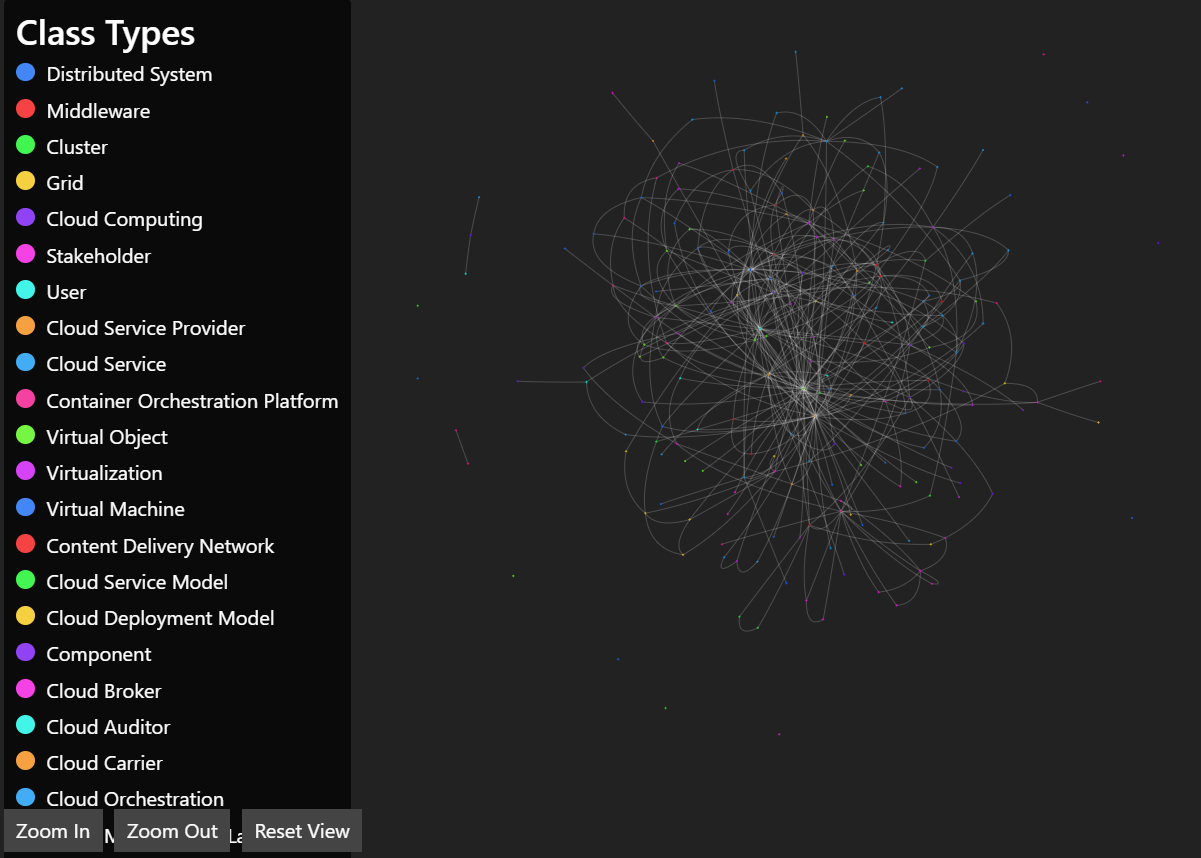

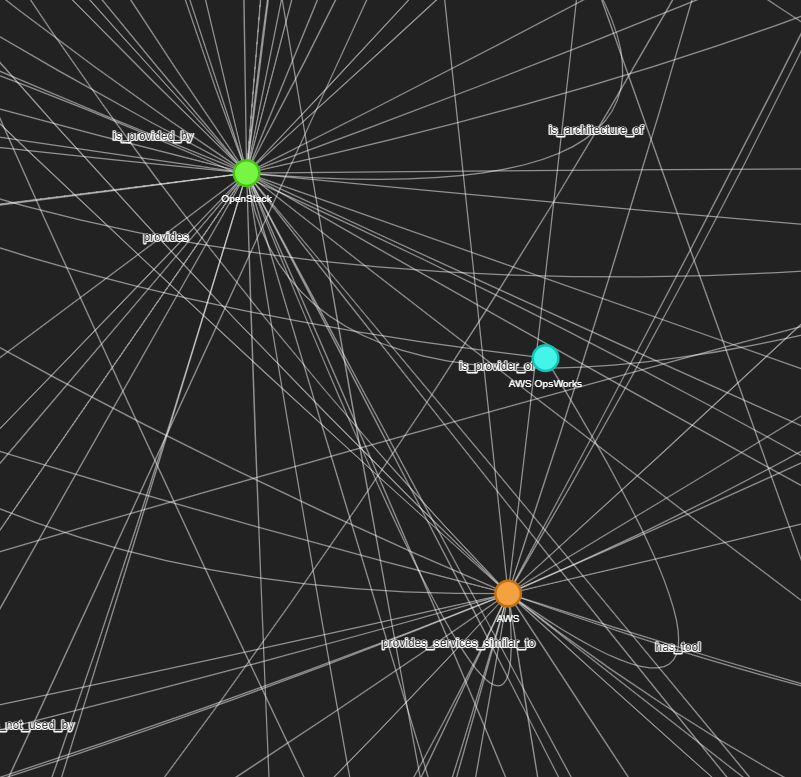

## Step 5: Storing Entities in ApertureDB

This step stores our extracted entities in ApertureDB to build our knowledge graph.

First we define a function to establish a connection to our ApertureDB instance.

In [137]:
# Define ApertureDB connection and setup functions
def create_db_connection(host=None, user="admin", password=None):
    """
    Create a connection to ApertureDB.

    Args:
        host: ApertureDB host URL
        user: Username for authentication
        password: Password for authentication

    Returns:
        Connector: ApertureDB connector object
    """
    # Use parameters from environment if not provided
    if host is None:
        host = db_host
    if password is None:
        password = db_password

    if not host or not password:
        raise ValueError("Missing ApertureDB credentials. Please set db_host and db_password.")

    try:
        connector = Connector.Connector(
            host=host,
            user=user,
            password=password
        )
        logger.info("Successfully connected to ApertureDB")
        return connector
    except Exception as e:
        logger.error(f"Failed to connect to ApertureDB: {str(e)}")
        raise

Let's test our connection.

In [138]:
client = create_db_connection(db_host, "admin", db_password)
response, _ = client.query([{"GetStatus": {}}])

client.print_last_response()

[
    {
        "GetStatus": {
            "info": "OK",
            "status": 0,
            "system": "ApertureDB",
            "version": "0.18.9"
        }
    }
]


Loads entity data from file.

In [100]:
def load_knowledge_graph_data():
    """
    Load entity data from the output of previous steps.

    Returns:
        tuple: deduplicated_entities
    """
    # Load entities (nodes)
    try:
        with open("deduplicated_entities.json", "r") as f:
            deduplicated_entities = json.load(f)
            logger.info(f"Loaded entities from deduplicated_entities.json")
    except FileNotFoundError:
        logger.error("deduplicated_entities.json not found. Please complete Step 3 first.")
        return None, None

    return deduplicated_entities

Let's define a function which creates indexes in ApertureDB for each entity class for efficient querying. We will create an index on the id property.

In [101]:
def ensure_class_indexes(client, class_types):
    """
    Create indexes for each class type's id property to optimize queries.

    Args:
        client: ApertureDB connector
        class_types: List of class types to create indexes for

    Returns:
        bool: True if successful, False otherwise
    """
    success = True

    for class_type in class_types:
        # Create index for the "id" property for this class type
        query = [{
            "CreateIndex": {
                "class_name": class_type,
                "property_name": "id",
                "index_type": "integer"  # Using integer index for ID values
            }
        }]

        try:
            response, _ = client.query(query)
            if "CreateIndex" in response[0] and response[0]["CreateIndex"]["status"] == 0:
                logger.info(f"Created index for {class_type}.id")
            else:
                logger.warning(f"Index creation response: {response[0]}")
        except Exception as e:
            # Index may already exist, which is fine
            logger.debug(f"Index for {class_type}.id may already exist: {str(e)}")

    return success

Now we deg=fine a function responsible for processing a single entity for insertion into ApertureDB.

In [111]:
def process_entity(args):
    """
    Process and insert a single entity into ApertureDB.
    """
    class_type, entity_name, properties, connector_params = args

    try:
        # Create a new connection for this thread
        client = create_db_connection(**connector_params)

        # Extract the integer ID
        entity_id = properties.get("id")
        if not entity_id:
            return {
                "status": "error",
                "class_type": class_type,
                "name": entity_name,
                "error": "Missing ID"
            }

        # Convert all property values to strings - keep the ID as an integer
        string_properties = {}
        for key, value in properties.items():
            if value is not None:
                if key == "id":
                    # Keep ID as an integer
                    string_properties[key] = int(value)
                else:
                    # Convert other properties to strings
                    string_properties[key] = str(value)

        # Ensure name property is set
        if "name" not in string_properties and entity_name:
            string_properties["name"] = str(entity_name)


        query = [{
            "AddEntity": {
                "class": class_type,
                "properties": string_properties,
                "if_not_found": {
                    "id": ["==", entity_id]
                }
            }
        }]

        # Execute query
        response, _ = client.query(query)

        # Check response
        if "AddEntity" in response[0] and response[0]["AddEntity"]["status"] == 0:
            return {
                "status": "success",
                "class_type": class_type,
                "id": entity_id,
                "name": entity_name,
                "ref": response[0]["AddEntity"].get("entity", {}).get("_ref", "")
            }
        else:
            return {
                "status": "error",
                "class_type": class_type,
                "id": entity_id,
                "name": entity_name,
                "error": str(response)
            }

    except Exception as e:
        return {
            "status": "exception",
            "class_type": class_type,
            "id": properties.get("id", "unknown"),
            "name": entity_name,
            "error": str(e)
        }

ApertureDB supports parallelisation which is useful as we have many entities to insert. This function inserts entities into ApertureDB in parallel for better performance.

In [112]:
def insert_entities_parallel(entities, connector_params, max_workers=10, batch_size=50):
    """
    Insert entities into ApertureDB using parallel processing.

    Args:
        entities: List of class data objects from deduplicated_entities.json
        connector_params: Dictionary of parameters for creating ApertureDB connections
        max_workers: Maximum number of parallel workers
        batch_size: Entities to process in each batch

    Returns:
        tuple: (success_count, error_count, total_time)
    """
    start_time = time.time()
    logger.info(f"Beginning entity insertion with {max_workers} workers")

    # Extract unique class types
    class_types = [class_obj["Class"] for class_obj in entities]

    # Create main client and ensure indexes
    main_client = create_db_connection(**connector_params)
    ensure_class_indexes(main_client, class_types)

    # Prepare entities for processing
    entity_tasks = []
    for class_obj in entities:
        class_type = class_obj["Class"]
        entities_dict = class_obj["Entities"]

        for entity_name, properties in entities_dict.items():
            entity_tasks.append((class_type, entity_name, properties, connector_params))

    total_entities = len(entity_tasks)
    logger.info(f"Found {total_entities} entities to insert")

    # Process entities in batches
    success_count = 0
    error_count = 0

    with tqdm(total=total_entities, desc="Inserting entities") as progress:
        for i in range(0, total_entities, batch_size):
            batch = entity_tasks[i:i+batch_size]

            # Process batch with parallel workers
            with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                results = list(executor.map(process_entity, batch))

            # Update counts
            batch_success = sum(1 for r in results if r["status"] == "success")
            batch_errors = len(batch) - batch_success

            success_count += batch_success
            error_count += batch_errors

            # Update progress
            progress.update(len(batch))

            # Log errors if any
            if batch_errors > 0:
                errors = [r for r in results if r["status"] != "success"]
                for error in errors[:5]:  # Show first 5 errors
                    logger.warning(f"Error: {error['class_type']} - {error['name']}: {error.get('error', 'Unknown error')}")

                if len(errors) > 5:
                    logger.warning(f"... and {len(errors) - 5} more errors")

            logger.info(f"Processed {min(i+batch_size, total_entities)}/{total_entities} entities - Success: {batch_success}, Errors: {batch_errors}")

    end_time = time.time()
    total_time = end_time - start_time

    logger.info(f"Entity insertion completed in {total_time:.2f} seconds")
    logger.info(f"Total: {total_entities}, Success: {success_count}, Errors: {error_count}")

    return success_count, error_count, total_time

A helper function that verifies entities were successfully inserted by retrieving samples.

In [113]:
def verify_entity_insertion(connector_params, class_types=None, limit=3):
    """
    Verify that entities were properly inserted by checking counts.

    Args:
        connector_params: Dictionary of parameters for creating ApertureDB connection
        class_types: List of class types to verify. If None, will check the first few types
        limit: Maximum number of class types to check

    Returns:
        dict: Dictionary with verification results
    """
    client = create_db_connection(**connector_params)

    # Load class data for comparison if class_types not provided
    if class_types is None:
        try:
            entities, _ = load_knowledge_graph_data()
            if entities is None:
                return {"status": "error", "message": "Could not load entity data for verification"}

            # Get a few class types
            class_types = [entities[i]["Class"] for i in range(min(limit, len(entities)))]
        except Exception as e:
            return {"status": "error", "message": f"Error loading entity data: {str(e)}"}

    results = {}
    print("\n----- Entity Verification -----")
    for class_type in class_types:
        # Count entities of this type in ApertureDB
        query = [{
            "FindEntity": {
                "class": class_type,
                "results": {
                    "count": True,
                    "list": ["id"]  # Retrieve id values to verify they exist
                }
            }
        }]

        try:
            response, _ = client.query(query)
            if "FindEntity" in response[0] and response[0]["FindEntity"]["status"] == 0:
                count = response[0]["FindEntity"].get("count", 0)
                print(f"{class_type}: {count} entities found in database")

                # If we got entities back, check a few id values
                sample_ids = []
                if "entities" in response[0]["FindEntity"] and len(response[0]["FindEntity"]["entities"]) > 0:
                    sample = response[0]["FindEntity"]["entities"][:2]  # Show first 2 entities
                    for entity in sample:
                        if "properties" in entity and "id" in entity["properties"]:
                            sample_ids.append(entity["properties"]["id"])
                    print(f"  Sample id values: {sample_ids}")

                results[class_type] = {
                    "count": count,
                    "sample_ids": sample_ids
                }
            else:
                print(f"{class_type}: Failed to get count - {response[0]}")
                results[class_type] = {
                    "status": "error",
                    "error": str(response[0])
                }
        except Exception as e:
            print(f"{class_type}: Error during verification - {str(e)}")
            results[class_type] = {
                "status": "exception",
                "error": str(e)
            }

    return results

Finally, this wrapper function wraps the entity storage process into a single function.

In [114]:
def process_step5(connector_params=None, max_entity_workers=10):
    """
    Execute Step 5: Insert entities into ApertureDB.

    Args:
        connector_params: Dictionary of parameters for creating ApertureDB connections.
                        If None, will use environment variables.
        max_entity_workers: Maximum number of parallel workers for entity insertion

    Returns:
        dict: Dictionary with operation results
    """
    print("Step 5: Inserting Entities into ApertureDB")

    # Prepare connection parameters
    if connector_params is None:
        connector_params = {
            "host": db_host,
            "user": "admin",
            "password": db_password
        }

    # Load data from previous steps
    entities = load_knowledge_graph_data()
    if entities is None:
        print("Error: Could not load entity data. Please complete previous steps first.")
        return None

    # Insert entities
    entity_success, entity_errors, entity_time = insert_entities_parallel(
        entities=entities,
        connector_params=connector_params,
        max_workers=max_entity_workers,
        batch_size=50  # Adjust based on entity complexity
    )

    # Verify entity insertion
    entity_verification = verify_entity_insertion(connector_params)

    # Summarize results
    print("\n----- Entity Insertion Summary -----")
    print(f"Entities: {entity_success} created, {entity_errors} errors, {entity_time:.2f} seconds")

    # Return all operation results
    return {
        "entities": {
            "success": entity_success,
            "errors": entity_errors,
            "time": entity_time,
            "verification": entity_verification
        }
    }

Now let's finally run step 5 to insert the entities into our databas instance.

In [115]:
# Run Step 5: Insert Entities into ApertureDB
connector_params = {
    "host": db_host,
    "user": "admin",
    "password": db_password
}

# Insert entities
entity_result = process_step5(connector_params)

Step 5: Inserting Entities into ApertureDB


Inserting entities: 100%|██████████| 199/199 [00:26<00:00,  7.49it/s]



----- Entity Verification -----
Distributed System: Error during verification - 0
Middleware: Error during verification - 0
Cluster: Error during verification - 0

----- Entity Insertion Summary -----
Entities: 199 created, 0 errors, 28.61 seconds


## Step 6: Creating Relationships in ApertureDB

This step creates edges between entity nodes to form our knowledge graph, using ApertureDB connections. We use our relationship schema dict here to easily create relationships using unique ids.

Let's create a function which loads relationship data from file.

In [116]:
# Step 6: Create relationships in ApertureDB

def load_relationships_data():
    """
    Load relationship data from the output of previous steps.

    Returns:
        list: List of relationships
    """
    try:
        with open("entity_relationships.json", "r") as f:
            relationships_data = json.load(f)
            relationships = relationships_data.get("relationships", [])
            logger.info(f"Loaded {len(relationships)} relationships from entity_relationships.json")
            return relationships
    except FileNotFoundError:
        logger.error("entity_relationships.json not found. Please complete Step 4 first.")
        return None

Let's define a function which processes a single relationship for insertion into ApertureDB. We first find the specific rleated entities by their id, then assign them temporary "_ref"s and finally create a relationship between them whose name is the class of the connection.

In [128]:
def process_relationship(args):
    """
    Process and create a single relationship between entities in ApertureDB.
    """
    relationship, connector_params = args

    try:
        # Create a connection for this thread
        client = create_db_connection(**connector_params)

        # Extract relationship information
        rel_type = relationship["relationship"]
        source_class_type = relationship["source"]["class_type"]
        source_entity_id = int(relationship["source"]["id"])
        dest_class_type = relationship["destination"]["class_type"]
        dest_entity_id = int(relationship["destination"]["id"])

        # Create a query that:
        # 1. Finds the source entity by class and ID
        # 2. Finds the destination entity by class and ID
        # 3. Creates a connection between them with relationship type as class
        query = [
            # Find source entity and assign reference 1
            {
                "FindEntity": {
                    "with_class": source_class_type,
                    "constraints": {
                        "id": ["==", source_entity_id]
                    },
                    "_ref": 1,  # Assign reference 1
                    "results": {
                        "count": True,
                        "list": ["id"]  # Added list parameter for better results
                    }
                }
            },
            # Find destination entity and assign reference 2
            {
                "FindEntity": {
                    "with_class": dest_class_type,
                    "constraints": {
                        "id": ["==", dest_entity_id]
                    },
                    "_ref": 2,  # Assign reference 2
                    "results": {
                        "count": True,
                        "list": ["id"]  # Added list parameter for better results
                    }
                }
            },
            # Create connection from source to destination
            {
                "AddConnection": {
                    "class": rel_type,
                    "src": 1,  # Reference to source entity
                    "dst": 2,  # Reference to destination entity
                    "properties": {
                        "created_at": time.strftime("%Y-%m-%d %H:%M:%S")
                    }
                }
            }
        ]

        # Execute the query
        response, _ = client.query(query)

        # Check for success
        source_found = False
        dest_found = False
        connection_created = False

        if len(response) >= 3:
            # Check if source entity was found
            if "FindEntity" in response[0] and response[0]["FindEntity"]["status"] == 0:
                source_count = response[0]["FindEntity"].get("count", 0)
                source_found = source_count > 0

            # Check if destination entity was found
            if "FindEntity" in response[1] and response[1]["FindEntity"]["status"] == 0:
                dest_count = response[1]["FindEntity"].get("count", 0)
                dest_found = dest_count > 0

            # Check if connection was created
            if "AddConnection" in response[2] and response[2]["AddConnection"]["status"] == 0:
                connection_created = True

        if source_found and dest_found and connection_created:
            return {
                "status": "success",
                "relationship": rel_type,
                "source": f"{source_class_type}:{source_entity_id}",
                "destination": f"{dest_class_type}:{dest_entity_id}"
            }
        else:
            error_details = {
                "source_found": source_found,
                "dest_found": dest_found,
                "connection_created": connection_created,
                "response": response
            }
            return {
                "status": "error",
                "relationship": rel_type,
                "source": f"{source_class_type}:{source_entity_id}",
                "destination": f"{dest_class_type}:{dest_entity_id}",
                "error": f"Failed to create connection: {error_details}"
            }

    except Exception as e:
        return {
            "status": "exception",
            "relationship": rel_type if 'rel_type' in locals() else "unknown",
            "source": f"{source_class_type}:{source_entity_id}" if 'source_class_type' in locals() else "unknown",
            "destination": f"{dest_class_type}:{dest_entity_id}" if 'dest_class_type' in locals() else "unknown",
            "error": str(e)
        }

Again, we use parallel processing here for faster operations. This function
inserts relationships in parallel for better performance.

In [129]:
def insert_relationships_parallel(relationships, connector_params, max_workers=5, batch_size=20):
    """
    Create relationships between entities in ApertureDB using parallel processing.

    Args:
        relationships: List of relationships from entity_relationships.json
        connector_params: Dictionary of parameters for creating ApertureDB connections
        max_workers: Maximum number of parallel workers
        batch_size: Relationships to process in each batch

    Returns:
        tuple: (success_count, error_count, total_time)
    """
    start_time = time.time()
    logger.info(f"Beginning relationship creation with {max_workers} workers")

    total_relationships = len(relationships)
    logger.info(f"Found {total_relationships} relationships to create")

    # Process relationships in batches
    success_count = 0
    error_count = 0

    # Prepare relationship data
    relationship_tasks = [(rel, connector_params) for rel in relationships]

    with tqdm(total=total_relationships, desc="Creating relationships") as progress:
        for i in range(0, total_relationships, batch_size):
            batch = relationship_tasks[i:i+batch_size]

            # Process batch with parallel workers
            with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                results = list(executor.map(process_relationship, batch))

            # Update counts
            batch_success = sum(1 for r in results if r["status"] == "success")
            batch_errors = len(batch) - batch_success

            success_count += batch_success
            error_count += batch_errors

            # Update progress
            progress.update(len(batch))

            # Log errors if any
            if batch_errors > 0:
                errors = [r for r in results if r["status"] != "success"]
                for error in errors[:3]:  # Show first 3 errors
                    logger.warning(f"Error: {error.get('relationship', 'unknown')} - {error.get('source', 'unknown')} → {error.get('destination', 'unknown')}: {error.get('error', 'Unknown error')}")

                if len(errors) > 3:
                    logger.warning(f"... and {len(errors) - 3} more errors")

    end_time = time.time()
    total_time = end_time - start_time

    logger.info(f"Relationship creation completed in {total_time:.2f} seconds")
    logger.info(f"Total: {total_relationships}, Success: {success_count}, Errors: {error_count}")

    return success_count, error_count, total_time

Let's create a helper function to verify relationships were successfully created by retrieving samples.

In [130]:
def verify_relationship_insertion(connector_params, relationship_types=None, limit=5):
    """
    Verify that relationships were properly created by checking counts.

    Args:
        connector_params: Dictionary of parameters for creating ApertureDB connection
        relationship_types: List of relationship types to verify. If None, will check the first few types
        limit: Maximum number of relationship types to check

    Returns:
        dict: Dictionary with verification results
    """
    client = create_db_connection(**connector_params)

    # Load relationship data for comparison if relationship_types not provided
    if relationship_types is None:
        try:
            relationships = load_relationships_data()
            if relationships is None:
                return {"status": "error", "message": "Could not load relationship data for verification"}

            # Get unique relationship types
            relationship_types = list(set(rel["relationship"] for rel in relationships))[:limit]
        except Exception as e:
            return {"status": "error", "message": f"Error loading relationship data: {str(e)}"}

    results = {}
    print("\n----- Relationship Verification -----")
    for rel_type in relationship_types:
        # Count connections of this type in ApertureDB
        query = [{
            "FindConnection": {
                "class": rel_type,
                "results": {
                    "count": True
                }
            }
        }]

        try:
            response, _ = client.query(query)
            if "FindConnection" in response[0] and response[0]["FindConnection"]["status"] == 0:
                count = response[0]["FindConnection"].get("count", 0)
                print(f"Relationship '{rel_type}': {count} connections found in database")
                results[rel_type] = {
                    "count": count
                }
            else:
                print(f"Relationship '{rel_type}': Failed to get count - {response[0]}")
                results[rel_type] = {
                    "status": "error",
                    "error": str(response[0])
                }
        except Exception as e:
            print(f"Relationship '{rel_type}': Error during verification - {str(e)}")
            results[rel_type] = {
                "status": "exception",
                "error": str(e)
            }

    return results

Finally, we define a wrapper function which wraps the relationship creation process into a single function.

In [131]:
def process_step6(connector_params=None, max_relationship_workers=5):
    """
    Execute Step 6: Create relationships in ApertureDB between existing entities.

    Args:
        connector_params: Dictionary of parameters for creating ApertureDB connections.
                        If None, will use environment variables.
        max_relationship_workers: Maximum number of parallel workers for relationship creation

    Returns:
        dict: Dictionary with operation results
    """
    print("Step 6: Creating Relationships in ApertureDB")

    # Prepare connection parameters
    if connector_params is None:
        connector_params = {
            "host": db_host,
            "user": "admin",
            "password": db_password
        }

    # Load relationship data
    relationships = load_relationships_data()
    if relationships is None:
        print("Error: Could not load relationship data. Please complete Step 4 first.")
        return None

    print(f"Found {len(relationships)} relationships to create in ApertureDB")

    # Create relationships
    relationship_success, relationship_errors, relationship_time = insert_relationships_parallel(
        relationships=relationships,
        connector_params=connector_params,
        max_workers=max_relationship_workers,
        batch_size=20  # Smaller batch size for more complex operations
    )

    # Verify relationship creation
    relationship_verification = verify_relationship_insertion(connector_params)

    # Summarize results
    print("\n----- Relationship Creation Summary -----")
    print(f"Relationships: {relationship_success} created, {relationship_errors} errors, {relationship_time:.2f} seconds")

    # Return all operation results
    return {
        "relationships": {
            "success": relationship_success,
            "errors": relationship_errors,
            "time": relationship_time,
            "verification": relationship_verification
        }
    }

Let's run step 6 and create relationships between the entities in our DB instance.

In [132]:
# Run Step 6: Create relationships between entities
connector_params = {
    "host": db_host,
    "user": "admin",
    "password": db_password
}

# Create relationships
relationship_result = process_step6(connector_params)

Step 6: Creating Relationships in ApertureDB
Found 519 relationships to create in ApertureDB


Creating relationships: 100%|██████████| 519/519 [02:12<00:00,  3.90it/s]



----- Relationship Verification -----
Relationship 'synchronizes': Error during verification - 0
Relationship 'uses_services_from': Error during verification - 0
Relationship 'manages': Error during verification - 0
Relationship 'is_part_of': Error during verification - 0
Relationship 'is_an_example_of': Error during verification - 0

----- Relationship Creation Summary -----
Relationships: 506 created, 13 errors, 132.92 seconds


Check out the entities and their relationships using your ApertureDB dashboard:

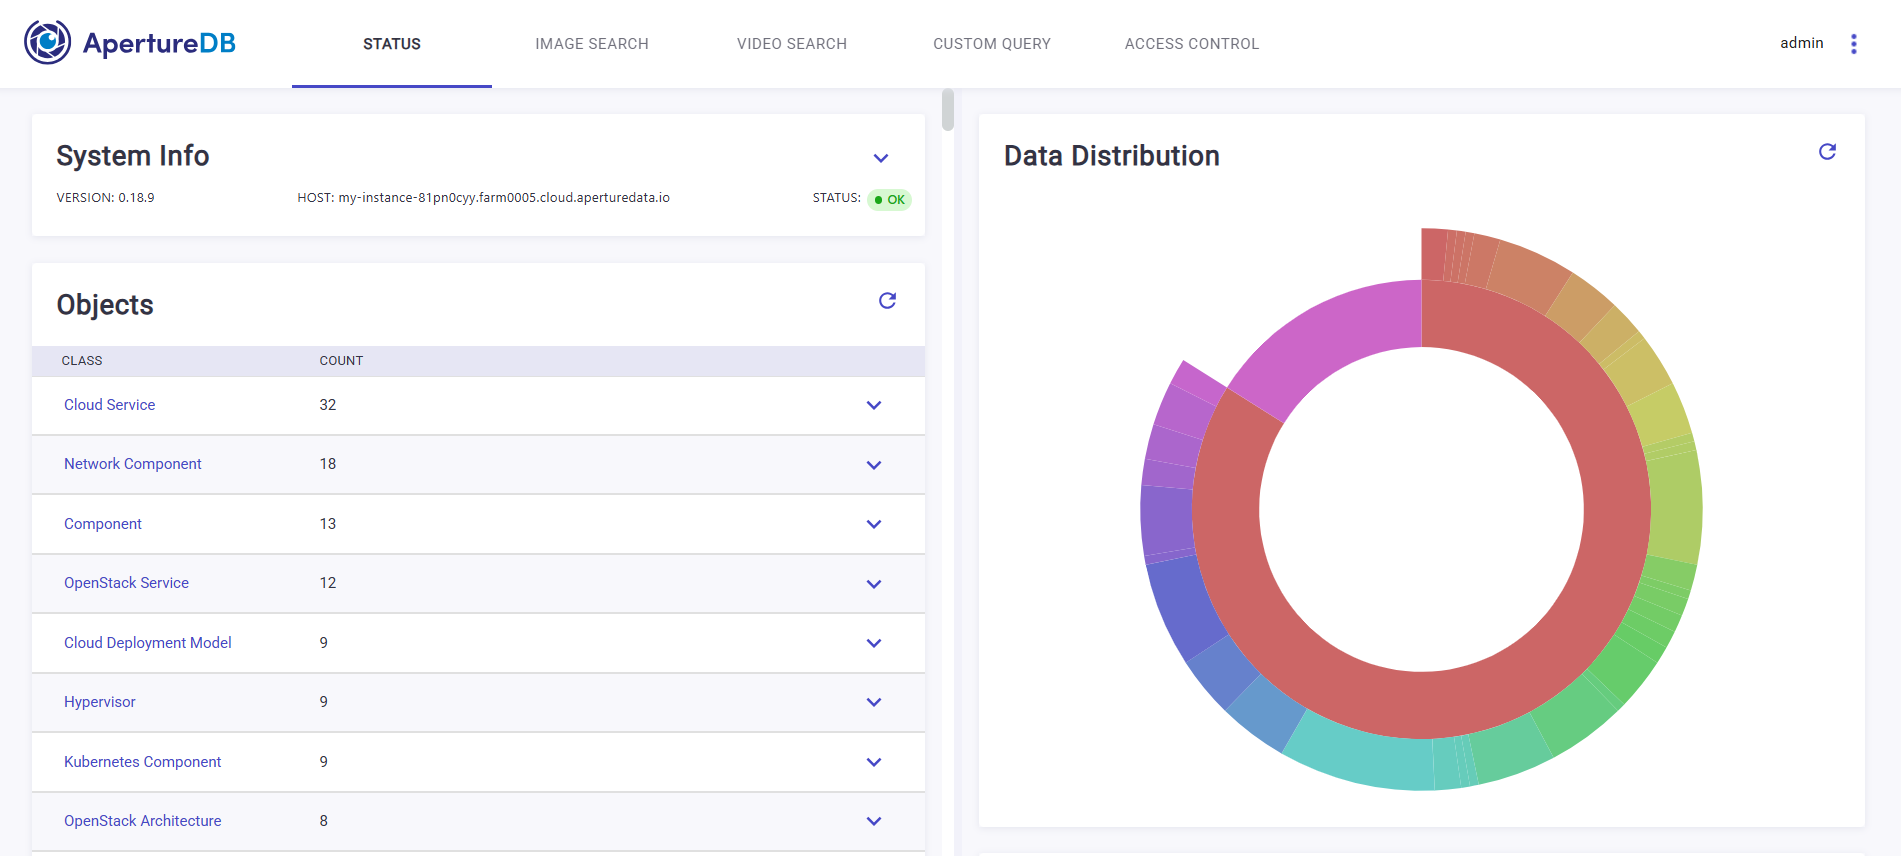

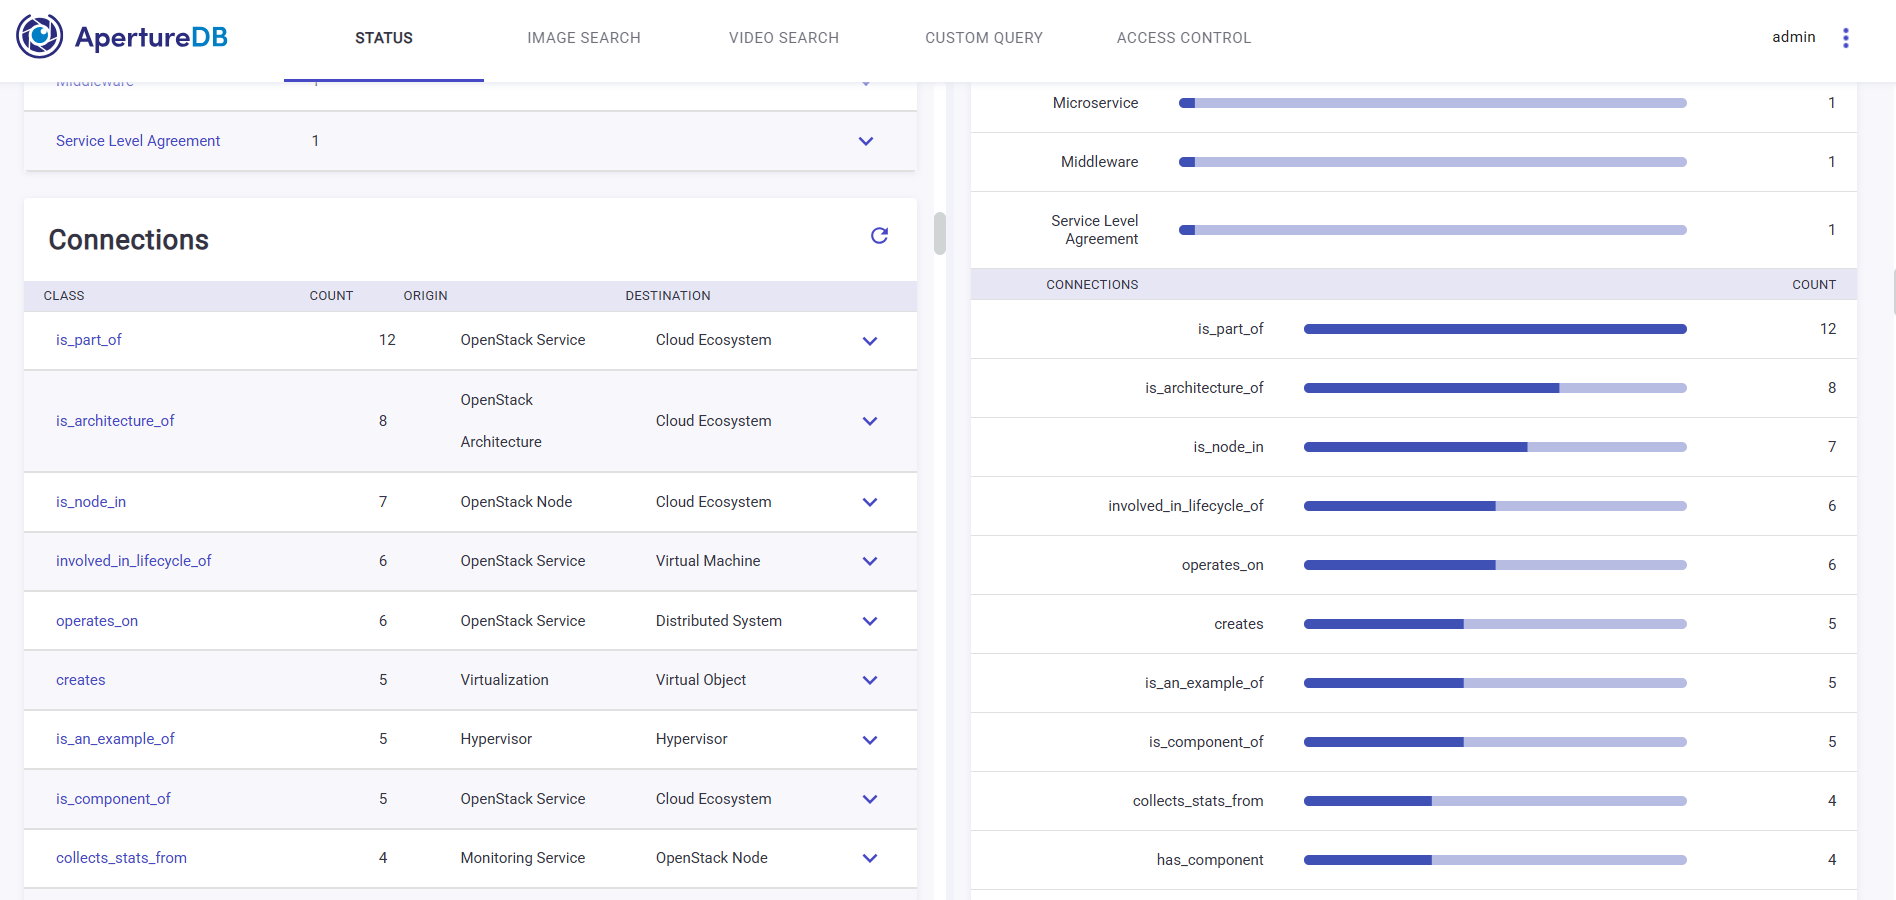

## Conclusion

Congratulations! You've built a complete knowledge graph pipeline that:

1. Automatically extracts entity classes from text
2. Identifies entity instances and their properties
3. Deduplicates entities and assigns unique IDs
4. Discovers relationships between entities
5. Stores everything in ApertureDB
6. Provides an interactive visualization

This knowledge graph can now be used for advanced querying, semantic search, and as a foundation for RAG systems. In a future tutorial, we'll explore how to use this knowledge graph to enhance retrieval and generation tasks.